In [1]:
!pip install magent2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 48.9 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.0/14.0 MB 104.8 MB/s eta 0:00:0000:010:01


In [2]:
!pip install pettingzoo==1.22.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.4/823.4 kB 30.3 MB/s eta 0:00:00
  Attempting uninstall: pettingzoo
    Found existing installation: pettingzoo 1.24.0
    Uninstalling pettingzoo-1.24.0:
      Successfully uninstalled pettingzoo-1.24.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
kaggle-environments 1.16.9 requires pettingzoo==1.24.0, but you have pettingzoo 1.22.0 which is incompatible.
magent2 0.3.3 requires pettingzoo>=1.23.1, but you have pettingzoo 1.22.0 which is incompatible.


In [3]:
!pip install torchrl

INFO: pip is looking at multiple versions of torchrl to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of tensordict to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 988.0/988.0 kB 46.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 336.1/336.1 kB 26.4 MB/s eta 0:00:00


In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from magent2.environments import battle_v4
import numpy as np
from torch.utils.tensorboard import SummaryWriter
import os
import datetime
from collections import deque
import random
import math
from torchrl.modules import NoisyLinear

class QNetworkWithNoisy(nn.Module):
    def __init__(self, observation_shape, action_shape):
        super().__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(observation_shape[-1], observation_shape[-1], 3),
            nn.SiLU(),
            nn.Conv2d(observation_shape[-1], observation_shape[-1], 3),
            nn.SiLU(),
        )
        dummy_input = torch.randn(observation_shape).permute(2, 0, 1)
        dummy_output = self.cnn(dummy_input)
        flatten_dim = dummy_output.view(-1).shape[0]
        self.network = nn.Sequential(
            NoisyLinear(flatten_dim, 120),
            # nn.LayerNorm(120),
            nn.ReLU(),
            NoisyLinear(120, 84),
            # nn.LayerNorm(84),
            nn.Tanh(),
        )
        self.last_layer = NoisyLinear(84, action_shape)

    def forward(self, x):
        assert len(x.shape) >= 3, "only support magent input observation"
        x = x.permute(0, 3, 1, 2)
        x = self.cnn(x)
        if len(x.shape) == 3:
            batchsize = 1
        else:
            batchsize = x.shape[0]
        x = x.reshape(batchsize, -1)
        x = self.network(x)
        self.last_latent = x
        return self.last_layer(x)

    def reset_noise(self):
        for m in self.modules():
            if isinstance(m, NoisyLinear):
                m.reset_noise()

/opt/conda/lib/python3.10/site-packages/torchrl/data/replay_buffers/samplers.py:37: UserWarning: Failed to import torchrl C++ binaries. Some modules (eg, prioritized replay buffers) may not work with your installation. If you installed TorchRL from PyPI, please report the bug on TorchRL github. If you installed TorchRL locally and/or in development mode, check that you have all the required compiling packages.
  warnings.warn(EXTENSION_WARNING)


In [5]:
class RedQNetwork(nn.Module):
    def __init__(self, observation_shape, action_shape):
        super().__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(observation_shape[-1], observation_shape[-1], 3),
            nn.ReLU(),
            nn.Conv2d(observation_shape[-1], observation_shape[-1], 3),
            nn.ReLU(),
        )
        dummy_input = torch.randn(observation_shape).permute(2, 0, 1)
        dummy_output = self.cnn(dummy_input)
        flatten_dim = dummy_output.view(-1).shape[0]
        self.network = nn.Sequential(
            nn.Linear(flatten_dim, 120),
            nn.ReLU(),
            nn.Linear(120, 84),
            nn.ReLU(),
            nn.Linear(84, action_shape),
        )

    def forward(self, x):
        assert len(x.shape) >= 3, "only support magent input observation"
        x = self.cnn(x)
        if len(x.shape) == 3:
            batchsize = 1
        else:
            batchsize = x.shape[0]
        x = x.reshape(batchsize, -1)
        return self.network(x)

In [6]:
class FinalRedQNetwork(nn.Module):
    def __init__(self, observation_shape, action_shape):
        super().__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(observation_shape[-1], observation_shape[-1], 3),
            nn.ReLU(),
            nn.Conv2d(observation_shape[-1], observation_shape[-1], 3),
            nn.ReLU(),
        )
        dummy_input = torch.randn(observation_shape).permute(2, 0, 1)
        dummy_output = self.cnn(dummy_input)
        flatten_dim = dummy_output.view(-1).shape[0]
        self.network = nn.Sequential(
            nn.Linear(flatten_dim, 120),
            # nn.LayerNorm(120),
            nn.ReLU(),
            nn.Linear(120, 84),
            # nn.LayerNorm(84),
            nn.Tanh(),
        )
        self.last_layer = nn.Linear(84, action_shape)

    def forward(self, x):
        assert len(x.shape) >= 3, "only support magent input observation"
        x = self.cnn(x)
        if len(x.shape) == 3:
            batchsize = 1
        else:
            batchsize = x.shape[0]
        x = x.reshape(batchsize, -1)
        x = self.network(x)
        self.last_latent = x
        return self.last_layer(x)


In [7]:
# --- Prioritized Replay Buffer ---
class PrioritizedReplayBuffer:
    def __init__(self, capacity, alpha=0.6, beta_start=0.4, beta_frames=100000):
        self.capacity = capacity
        self.buffer = []
        self.priorities = np.zeros((capacity,), dtype=np.float32)
        self.alpha = alpha
        self.beta_start = beta_start
        self.beta_frames = beta_frames
        self.frame = 1
        self.pos = 0
        self.max_priority = 1.0

    def push(self, state, action, reward, next_state, done):
        if len(self.buffer) < self.capacity:
            self.buffer.append((state, action, reward, next_state, done))
        else:
            self.buffer[self.pos] = (state, action, reward, next_state, done)

        self.priorities[self.pos] = self.max_priority
        self.pos = (self.pos + 1) % self.capacity

    def sample(self, batch_size):
        if len(self.buffer) == self.capacity:
            prios = self.priorities
        else:
            prios = self.priorities[:self.pos]

        probs = prios ** self.alpha
        probs /= probs.sum()

        indices = np.random.choice(len(self.buffer), batch_size, p=probs)
        samples = [self.buffer[idx] for idx in indices]

        beta = self.beta_start + (1.0 - self.beta_start) * self.frame / self.beta_frames
        self.frame = min(self.frame + 1, self.beta_frames)

        weights = (len(self.buffer) * probs[indices]) ** (-beta)
        weights /= weights.max()
        weights = np.array(weights, dtype=np.float32)

        state, action, reward, next_state, done = zip(*samples)
        return state, action, reward, next_state, done, indices, weights

    def update_priorities(self, batch_indices, batch_priorities):
        for idx, prio in zip(batch_indices, batch_priorities):
            self.priorities[idx] = prio
            self.max_priority = max(self.max_priority, prio)

    def __len__(self):
        return len(self.buffer)


In [8]:
def evaluate_checkpoint(q_network, red_q_network, pretrain_policy, num_episodes=5):
    env = battle_v4.parallel_env(map_size=45, max_cycles=1000, minimap_mode=False)
    total_steps = 0
    total_rewards_random = 0
    total_rewards_pretrained = 0

    for _ in range(num_episodes):
        # --- Evaluate against random policy ---
        observations = env.reset()
        done_agents = set()
        episode_reward_random = 0
        while True:
            actions = {}
            red_agents = [agent for agent in env.agents if agent.startswith("red_") and agent not in done_agents]
            blue_agents = [agent for agent in env.agents if agent.startswith("blue_") and agent not in done_agents]

            if red_agents:
                for agent in red_agents:
                    actions[agent] = env.action_spaces[agent].sample()  # Random action

            if blue_agents:
                states_blue = torch.stack([
                    torch.tensor(observations[agent], dtype=torch.float32)
                    for agent in blue_agents
                ]).to(device)
                with torch.no_grad():
                    q_network_blue.reset_noise()
                    q_values_blue = q_network(states_blue)
                    selected_actions_blue = torch.argmax(q_values_blue, dim=1)

                for idx, agent in enumerate(blue_agents):
                    actions[agent] = selected_actions_blue[idx].item()

            next_obs, rewards, terminations, truncations, infos = env.step(actions)
            done_agents.update([agent for agent, terminated in terminations.items() if terminated])
            observations = next_obs
            episode_reward_random += sum(rewards.get(agent, 0.0) for agent in blue_agents)
            if all(terminations.values()) or all(truncations.values()):
                total_rewards_random += episode_reward_random
                break

        # --- Evaluate against pretrained policy ---
        observations = env.reset()
        done_agents = set()
        episode_reward_pretrained = 0
        while True:
            actions = {}
            red_agents = [agent for agent in env.agents if agent.startswith("red_") and agent not in done_agents]
            blue_agents = [agent for agent in env.agents if agent.startswith("blue_") and agent not in done_agents]

            if red_agents:
                for agent in red_agents:
                    actions[agent] = pretrain_policy(env, agent, observations[agent])  # Pretrained action

            if blue_agents:
                states_blue = torch.stack([
                    torch.tensor(observations[agent], dtype=torch.float32)
                    for agent in blue_agents
                ]).to(device)
                with torch.no_grad():
                    q_network_blue.reset_noise()
                    q_values_blue = q_network(states_blue)
                    selected_actions_blue = torch.argmax(q_values_blue, dim=1)

                for idx, agent in enumerate(blue_agents):
                    actions[agent] = selected_actions_blue[idx].item()

            next_obs, rewards, terminations, truncations, infos = env.step(actions)
            done_agents.update([agent for agent, terminated in terminations.items() if terminated])
            observations = next_obs
            episode_reward_pretrained += sum(rewards.get(agent, 0.0) for agent in blue_agents)
            if all(terminations.values()) or all(truncations.values()):
                total_rewards_pretrained += episode_reward_pretrained
                break

    avg_reward_random = total_rewards_random / num_episodes
    avg_reward_pretrained = total_rewards_pretrained / num_episodes
    avg_reward = (avg_reward_random + avg_reward_pretrained) / 2

    return avg_reward, avg_reward_random, avg_reward_pretrained


In [9]:
# --- Initialize environment and device ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# --- TensorBoard writer ---
log_dir = os.path.join("runs", "Dueling_Noisy_DDQN_BattleV4_PER_" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
writer = SummaryWriter(log_dir=log_dir)

# --- Initialize the environment ---
env = battle_v4.parallel_env(map_size=45, max_cycles=1000, minimap_mode=False)

sample_observation = env.observation_spaces[env.agents[0]].shape
state_space = sample_observation
action_space = env.action_spaces[env.agents[0]].n

# --- Initialize networks and optimizers ---
q_network_blue = QNetworkWithNoisy(state_space, action_space).to(device)
target_network_blue = QNetworkWithNoisy(state_space, action_space).to(device)
target_network_blue.load_state_dict(q_network_blue.state_dict())
target_network_blue.eval()

optimizer_blue = optim.Adam(q_network_blue.parameters(), lr=0.0005)

# --- Hyperparameters ---
gamma = 0.99
num_episodes = 250
max_steps_per_episode = 1000
checkpoint_interval = 5
polyak_tau = 0.005
replay_buffer_size = 500000
batch_size = 4096
num_val_episodes = 5

# --- Initialize prioritized replay buffers ---
replay_buffer_blue = PrioritizedReplayBuffer(replay_buffer_size)

red_q_network = RedQNetwork(state_space, action_space).to(device)  # Assuming same architecture
red_q_network.load_state_dict(torch.load("red.pt", map_location=device, weights_only = True))
red_q_network.eval()

def pretrain_policy(env, agent, obs):
    observation = (torch.Tensor(obs).float().permute([2, 0, 1]).unsqueeze(0).to(device))
    with torch.no_grad():
        red_q_values = red_q_network(observation)
    return torch.argmax(red_q_values, dim=1).cpu().numpy()[0]
# --- Training loop ---
best_val = -float('inf')
best_checkpoint = ""
for episode in range(0, num_episodes + 1):
    observations = env.reset()
    total_reward_blue = 0
    done_agents = set()

    for step in range(max_steps_per_episode):
        actions = {}
        red_agents = [agent for agent in env.agents if agent.startswith("red_") and agent not in done_agents]
        blue_agents = [agent for agent in env.agents if agent.startswith("blue_") and agent not in done_agents]

        # --- Process all blue agents ---
        if blue_agents:
            states_blue = torch.stack([
                torch.tensor(observations[agent], dtype=torch.float32)
                for agent in blue_agents
            ]).to(device)

            # --- Select actions with Noisy Networks ---
            with torch.no_grad():
                q_network_blue.reset_noise()
                q_values_blue = q_network_blue(states_blue)
                selected_actions_blue = torch.argmax(q_values_blue, dim=1)

            for idx, agent in enumerate(blue_agents):
                actions[agent] = selected_actions_blue[idx].item()

        # --- Process all red agents ---
        if red_agents:
            selected_actions_red = torch.randint(0, action_space, (len(red_agents),), device=device)
            for idx, agent in enumerate(red_agents):
                actions[agent] = selected_actions_red[idx].item()

        # --- Take step in environment ---

        next_obs, rewards, terminations, truncations, infos = env.step(actions)
        # --- Update total rewards ---
        total_reward_blue += sum(rewards.get(agent, 0.0) for agent in blue_agents)
        # --- Store experiences in replay buffers ---
        for agent in blue_agents:
            next_state = next_obs.get(agent) if not terminations.get(agent, False) else observations[agent]  # Use current state as next state if agent is done
            replay_buffer_blue.push(
                observations[agent],
                actions[agent],
                rewards.get(agent, 0.0),
                next_state,
                terminations.get(agent, False)  # Only consider termination as done
            )
        # --- Train blue network on a batch sampled from replay buffer ---
        if len(replay_buffer_blue) >= batch_size:
            state_batch, action_batch, reward_batch, next_state_batch, done_batch, indices, weights = replay_buffer_blue.sample(batch_size)

            current_states_blue = torch.tensor(np.array(state_batch), dtype=torch.float32).to(device)
            current_actions_blue = torch.tensor(action_batch, dtype=torch.long).unsqueeze(1).to(device)
            next_states_blue = torch.tensor(np.array(next_state_batch), dtype=torch.float32).to(device)
            rewards_blue = torch.tensor(reward_batch, dtype=torch.float32).unsqueeze(1).to(device)
            dones_blue = torch.tensor(done_batch, dtype=torch.float32).unsqueeze(1).to(device)
            weights_tensor_blue = torch.tensor(weights, dtype=torch.float32).unsqueeze(1).to(device)

            q_network_blue.reset_noise()
            target_network_blue.reset_noise()
            current_q_values_blue = q_network_blue(current_states_blue).gather(1, current_actions_blue)
            with torch.no_grad():
                actions = q_network_blue(next_states_blue).max(1, keepdim=True)[1]
                next_q_values_blue = target_network_blue(next_states_blue).gather(1, actions)
                target_q_values_blue = rewards_blue + gamma * next_q_values_blue * (1 - dones_blue)

            td_errors = (target_q_values_blue - current_q_values_blue).abs().detach().cpu().numpy()
            new_priorities = td_errors + 1e-6
            replay_buffer_blue.update_priorities(indices, new_priorities)

            loss_blue = (weights_tensor_blue * nn.SmoothL1Loss(reduction='none')(current_q_values_blue, target_q_values_blue)).mean()

            optimizer_blue.zero_grad()
            loss_blue.backward()
            nn.utils.clip_grad_norm_(q_network_blue.parameters(), 1.0)
            optimizer_blue.step()

            writer.add_scalar('Loss/Blue', loss_blue.item(), episode * max_steps_per_episode + step)

        # --- Soft update target networks ---
        for target_param, param in zip(target_network_blue.parameters(), q_network_blue.parameters()):
            target_param.data.copy_(polyak_tau * param.data + (1 - polyak_tau) * target_param.data)

        observations = next_obs
        done_agents.update([agent for agent, terminated in terminations.items() if terminated])

        if all(terminations.values()) or (truncations and all(truncations.values())):
            break

    # --- Log episode statistics ---
    # --- Log episode statistics ---
    writer.add_scalar('Total Reward/Blue', total_reward_blue, episode)
    print(f"Episode {episode}/{num_episodes}, Total Reward Blue: {total_reward_blue:.2f}")
    # --- Save checkpoints and evaluate ---
    if episode % checkpoint_interval == 0:
        checkpoint_path = f"blue_agent_dueling_ddqn_noise_per_ep{episode}.pth"
        torch.save(q_network_blue.state_dict(), checkpoint_path)
        val_reward, val_reward_random, val_reward_pretrained = evaluate_checkpoint(q_network_blue, red_q_network, pretrain_policy, num_val_episodes)
        writer.add_scalar('Validation/Average Reward', val_reward, episode)
        writer.add_scalar('Validation/Average Reward vs Random', val_reward_random, episode)
        writer.add_scalar('Validation/Average Reward vs Pretrained', val_reward_pretrained, episode)
        print(f"Episode {episode}: Validation average reward = {val_reward:.2f}, "
              f"vs Random = {val_reward_random:.2f}, vs Pretrained = {val_reward_pretrained:.2f}")
        if val_reward >= best_val:
            best_val = val_reward
            if best_checkpoint:
                os.remove(best_checkpoint)
            best_checkpoint = checkpoint_path
            print(f"New best checkpoint saved at {best_checkpoint}")
        if val_reward < best_val:
            os.remove(checkpoint_path)
if best_checkpoint:
    best_checkpoint_final = "blue_agent_dueling_ddqn_noise_per_best.pth"
    os.rename(best_checkpoint, best_checkpoint_final)
    print(f"Training complete. Best model saved at {best_checkpoint_final}")
else:
    torch.save(q_network_blue.state_dict(), "blue_agent_dueling_ddqn_noise_per_final.pth")
    print(f"Training complete. Final model saved at blue_agent_dueling_ddqn_per_final.pth")

Using device: cuda


/tmp/ipykernel_23/2464537133.py:47: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  self.priorities[idx] = prio


Episode 0/250, Total Reward Blue: -122.77
Episode 0: Validation average reward = -58.33, vs Random = -165.71, vs Pretrained = 49.06
New best checkpoint saved at blue_agent_dueling_ddqn_noise_per_ep0.pth
Episode 1/250, Total Reward Blue: 269.82
Episode 2/250, Total Reward Blue: 59.53
Episode 3/250, Total Reward Blue: 301.27
Episode 4/250, Total Reward Blue: 203.84
Episode 5/250, Total Reward Blue: 350.48
Episode 5: Validation average reward = 173.46, vs Random = 293.50, vs Pretrained = 53.43
New best checkpoint saved at blue_agent_dueling_ddqn_noise_per_ep5.pth
Episode 6/250, Total Reward Blue: 356.24
Episode 7/250, Total Reward Blue: -19.59
Episode 8/250, Total Reward Blue: 367.60
Episode 9/250, Total Reward Blue: 329.55
Episode 10/250, Total Reward Blue: 354.74
Episode 10: Validation average reward = 188.73, vs Random = 352.68, vs Pretrained = 24.77
New best checkpoint saved at blue_agent_dueling_ddqn_noise_per_ep10.pth
Episode 11/250, Total Reward Blue: 369.21
Episode 12/250, Total R

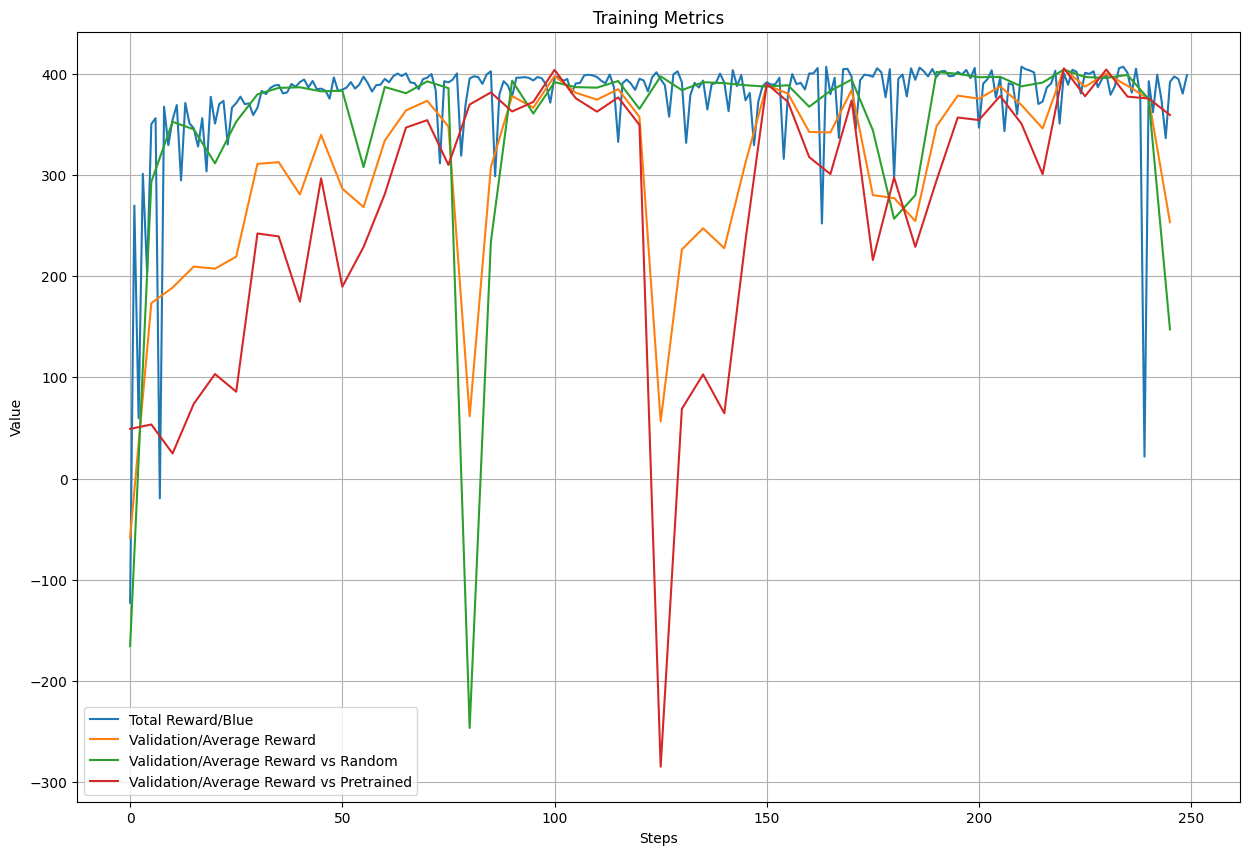

In [10]:
import matplotlib.pyplot as plt
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
import os

# --- Function to extract data from TensorBoard logs ---
def extract_data_from_logs(log_dir, tags):
    event_acc = EventAccumulator(log_dir)
    event_acc.Reload()
    data = {tag: [] for tag in tags}

    for tag in tags:
        events = event_acc.Scalars(tag)
        for event in events:
            data[tag].append((event.step, event.value))

    return data

# --- Set log directory ---
log_dir = "runs"  # Replace with the directory where TensorBoard logs are stored
latest_run = max([os.path.join(log_dir, d) for d in os.listdir(log_dir)], key=os.path.getmtime)

# --- Tags to plot ---
tags_to_plot = ['Total Reward/Blue','Validation/Average Reward','Validation/Average Reward vs Random','Validation/Average Reward vs Pretrained']
data = extract_data_from_logs(latest_run, tags_to_plot)

# --- Plot data ---
plt.figure(figsize=(15, 10))
for tag in tags_to_plot:
    steps, values = zip(*data[tag])
    plt.plot(steps, values, label=tag)

plt.xlabel("Steps")
plt.ylabel("Value")
plt.title("Training Metrics")
plt.legend()
plt.grid(True)
plt.show()


In [11]:

# Initialize environment and device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
import cv2
if __name__ == "__main__":
    # Initialize environment
    env = battle_v4.env(map_size=45, render_mode="rgb_array")
    vid_dir = "video"
    os.makedirs(vid_dir, exist_ok=True)
    fps = 35

    env.reset()
    frames = []

    # Load the pretrained model
    model_path = "blue_agent_dueling_ddqn_noise_per_best.pth"  # Adjust path as needed
    sample_observation = env.observation_spaces[env.agents[0]].shape
    state_space = sample_observation  # Dynamic observation shape
    action_space = env.action_spaces[env.agents[0]].n

    blue_q_network = QNetworkWithNoisy(state_space, action_space).to(device)
    checkpoint = torch.load(model_path, map_location=device, weights_only = True)
    blue_q_network.load_state_dict(checkpoint)
    blue_q_network.eval()

    red_q_network = RedQNetwork(state_space, action_space).to(device)
    red_q_network.load_state_dict(torch.load("red.pt", weights_only=True, map_location="cpu"))
    red_q_network.eval()

    for agent in env.agent_iter():
        observation, reward, termination, truncation, info = env.last()

        if termination or truncation:
            action = None  # This agent has died
        else:
            if agent.startswith("red"):
                observation = (
                    torch.Tensor(observation).float().permute([2, 0, 1]).unsqueeze(0).to(device)
                )
                with torch.no_grad():
                   red_q_values = red_q_network(observation)
                   action = torch.argmax(red_q_values, dim=1).cpu().numpy()[0]
            else:
                obs = torch.tensor(observation, dtype=torch.float32).unsqueeze(0).to(device)
                with torch.no_grad():
                    blue_q_network.reset_noise()
                    blue_q_values = blue_q_network(obs)
                action = int(torch.argmax(blue_q_values, dim=1).item())
        env.step(action)

        if agent == "blue_12" or agent == "blue_77" or agent == "blue_37" or agent == "blue_7":
            frames.append(env.render())

    # Save the video
    height, width, _ = frames[0].shape
    out = cv2.VideoWriter(
        os.path.join(vid_dir, f"pretrained_agents.mp4"),
        cv2.VideoWriter_fourcc(*"mp4v"),
        fps,
        (width, height),
    )
    for frame in frames:
        frame_bgr = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
        out.write(frame_bgr)
    out.release()
    print("Done recording pretrained agents")

    env.close()

Using device: cuda


/opt/conda/lib/python3.10/site-packages/pettingzoo/utils/wrappers/base.py:50: UserWarning: The `observation_spaces` dictionary is deprecated. Use the `observation_space` function instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/pettingzoo/utils/wrappers/base.py:64: UserWarning: The `action_spaces` dictionary is deprecated. Use the `action_space` function instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/pygame/pkgdata.py:25: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import resource_stream, resource_exists
/opt/conda/lib/python3.10/site-packages/pkg_resources/__init__.py:2825: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-

Done recording pretrained agents


In [12]:

# Initialize environment and device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
import cv2
if __name__ == "__main__":
    # Initialize environment
    env = battle_v4.env(map_size=45, render_mode="rgb_array")
    vid_dir = "video"
    os.makedirs(vid_dir, exist_ok=True)
    fps = 35

    env.reset()
    frames = []

    # Load the pretrained model
    model_path = "blue_agent_dueling_ddqn_noise_per_best.pth"  # Adjust path as needed
    sample_observation = env.observation_spaces[env.agents[0]].shape
    state_space = sample_observation  # Dynamic observation shape
    action_space = env.action_spaces[env.agents[0]].n

    blue_q_network = QNetworkWithNoisy(state_space, action_space).to(device)
    checkpoint = torch.load(model_path, map_location=device, weights_only = True)
    blue_q_network.load_state_dict(checkpoint)
    blue_q_network.eval()

    red_final_q_network = FinalRedQNetwork(state_space, action_space).to(device)
    red_final_q_network.load_state_dict(torch.load("red_final.pt", weights_only=True, map_location="cpu"))
    red_final_q_network.eval()

    for agent in env.agent_iter():
        observation, reward, termination, truncation, info = env.last()

        if termination or truncation:
            action = None  # This agent has died
        else:
            if agent.startswith("red"):
                observation = (
                    torch.Tensor(observation).float().permute([2, 0, 1]).unsqueeze(0).to(device)
                )
                with torch.no_grad():
                   red_final_q_values = red_final_q_network(observation)
                   action = torch.argmax(red_final_q_values, dim=1).cpu().numpy()[0]
            else:
                obs = torch.tensor(observation, dtype=torch.float32).unsqueeze(0).to(device)
                with torch.no_grad():
                    blue_q_network.reset_noise()
                    blue_q_values = blue_q_network(obs)
                action = int(torch.argmax(blue_q_values, dim=1).item())
        env.step(action)

        if agent == "blue_12" or agent == "blue_77" or agent == "blue_37" or agent == "blue_7":
            frames.append(env.render())

    # Save the video
    height, width, _ = frames[0].shape
    out = cv2.VideoWriter(
        os.path.join(vid_dir, f"pretrained_final_agents.mp4"),
        cv2.VideoWriter_fourcc(*"mp4v"),
        fps,
        (width, height),
    )
    for frame in frames:
        frame_bgr = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
        out.write(frame_bgr)
    out.release()
    print("Done recording pretrained final agents")

    env.close()

Using device: cuda


/opt/conda/lib/python3.10/site-packages/pettingzoo/utils/wrappers/base.py:50: UserWarning: The `observation_spaces` dictionary is deprecated. Use the `observation_space` function instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/pettingzoo/utils/wrappers/base.py:64: UserWarning: The `action_spaces` dictionary is deprecated. Use the `action_space` function instead.
  warnings.warn(


Done recording pretrained final agents


In [13]:

from magent2.environments import battle_v4
import torch
import numpy as np

try:
    from tqdm import tqdm
except ImportError:
    tqdm = lambda x, *args, **kwargs: x  # Fallback: tqdm becomes a no-op


def eval():
    max_cycles = 300
    env = battle_v4.env(map_size=45, max_cycles=max_cycles)
    device = "cuda" if torch.cuda.is_available() else "cpu"

    def random_policy(env, agent, obs):
        return env.action_space(agent).sample()

    red_q_network = RedQNetwork(state_space, action_space).to(device)
    red_q_network.load_state_dict(torch.load("red.pt", weights_only=True, map_location="cpu"))

    red_final_q_network = FinalRedQNetwork(state_space, action_space).to(device)
    red_final_q_network.load_state_dict(torch.load("red_final.pt", weights_only=True, map_location="cpu"))

    blue_q_network = QNetworkWithNoisy(state_space, action_space).to(device)
    blue_q_network.load_state_dict(torch.load("blue_agent_dueling_ddqn_noise_per_best.pth", map_location=device, weights_only=True))


    def pretrain_policy(env, agent, obs):
        observation = (
            torch.Tensor(obs).float().permute([2, 0, 1]).unsqueeze(0).to(device)
        )
        with torch.no_grad():
            red_q_values = red_q_network(observation)
        return torch.argmax(red_q_values, dim=1).cpu().numpy()[0]

    def final_pretrain_policy(env, agent, obs):
        observation = (
            torch.Tensor(obs).float().permute([2, 0, 1]).unsqueeze(0).to(device)
        )
        with torch.no_grad():
            red_final_q_values = red_final_q_network(observation)
        return torch.argmax(red_final_q_values, dim=1).cpu().numpy()[0]

    def my_model_pretrain_policy(env, agent, obs):
        observation = torch.tensor(obs, dtype=torch.float32).unsqueeze(0).to(device)
        with torch.no_grad():
            blue_q_network.reset_noise()
            blue_q_values = blue_q_network(observation)
        return int(torch.argmax(blue_q_values, dim=1).item())
    def run_eval(env, red_policy, blue_policy, n_episode: int = 100):
        red_win, blue_win = [], []
        red_tot_rw, blue_tot_rw = [], []
        n_agent_each_team = len(env.env.action_spaces) // 2

        for _ in tqdm(range(n_episode)):
            env.reset()
            n_kill = {"red": 0, "blue": 0}
            red_reward, blue_reward = 0, 0

            for agent in env.agent_iter():
                observation, reward, termination, truncation, info = env.last()
                agent_team = agent.split("_")[0]

                n_kill[agent_team] += (
                    reward > 4.5
                )  # This assumes default reward settups
                if agent_team == "red":
                    red_reward += reward
                else:
                    blue_reward += reward

                if termination or truncation:
                    action = None  # this agent has died
                else:
                    if agent_team == "red":
                        action = red_policy(env, agent, observation)
                    else:
                        action = blue_policy(env, agent, observation)

                env.step(action)

            who_wins = "red" if n_kill["red"] >= n_kill["blue"] + 5 else "draw"
            who_wins = "blue" if n_kill["red"] + 5 <= n_kill["blue"] else who_wins
            red_win.append(who_wins == "red")
            blue_win.append(who_wins == "blue")

            red_tot_rw.append(red_reward / n_agent_each_team)
            blue_tot_rw.append(blue_reward / n_agent_each_team)

        return {
            "winrate_red": np.mean(red_win),
            "winrate_blue": np.mean(blue_win),
            "average_rewards_red": np.mean(red_tot_rw),
            "average_rewards_blue": np.mean(blue_tot_rw),
        }

    print("=" * 20)
    print("Eval with random policy")
    print(
        run_eval(
            env=env, red_policy=random_policy, blue_policy=my_model_pretrain_policy, n_episode=30
        )
    )
    print("=" * 20)

    print("Eval with trained policy")
    print(
        run_eval(
            env=env, red_policy=pretrain_policy, blue_policy=my_model_pretrain_policy, n_episode=30
        )
    )
    print("=" * 20)

    print("Eval with final trained policy")
    print(
        run_eval(
            env=env, red_policy=final_pretrain_policy, blue_policy=my_model_pretrain_policy, n_episode=30
        )
    )
    print("=" * 20)


if __name__ == "__main__":
    eval()

Eval with random policy


100%|██████████| 30/30 [05:13<00:00, 10.45s/it]


{'winrate_red': 0.0, 'winrate_blue': 1.0, 'average_rewards_red': -1.0465020980946567, 'average_rewards_blue': 4.616199564094054}
Eval with trained policy


100%|██████████| 30/30 [03:19<00:00,  6.64s/it]


{'winrate_red': 0.0, 'winrate_blue': 0.9666666666666667, 'average_rewards_red': 3.390080222778345, 'average_rewards_blue': 4.866133722411508}
Eval with final trained policy


100%|██████████| 30/30 [04:29<00:00,  8.99s/it]

{'winrate_red': 0.8, 'winrate_blue': 0.06666666666666667, 'average_rewards_red': 4.348757173473959, 'average_rewards_blue': 3.82187857930951}
